In [18]:
import os
import re
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from googletrans import Translator
from sklearn.metrics import accuracy_score, classification_report
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
!pip install torch torchvision
!pip install googletrans==4.0.0-rc1
!pip install transformers
!pip install tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile

# Ruta al archivo tar.gz en Google Drive
ruta_archivo = '/content/drive/MyDrive/Inteligencia Artificial/aclImdb_v1.tar.gz'

# Ruta donde los archivos seran descomprimidos
ruta_extraido = '/content/dataset'

# Descomprimir el archivo tar.gz para poder acceder
with tarfile.open(ruta_archivo, 'r:gz') as tar:
    tar.extractall(ruta_extraido)

In [4]:
# Verificar si hay una GPU disponible o en su defecto usar cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo seleccionado:", device)

Dispositivo seleccionado: cuda


In [6]:
# Ruta donde se descomprimirán los archivos
extracted_path = '/content/dataset'

# Leer las reseñas y etiquetas
def read_reviews_and_labels(directory):
    reviews = []
    labels = []
    for sentiment in ['pos', 'neg']:
        sentiment_dir = os.path.join(directory, sentiment)
        for file in os.listdir(sentiment_dir):
            with open(os.path.join(sentiment_dir, file), 'r') as f:
                review = f.read()
                reviews.append(review)
                labels.append(1 if sentiment == 'pos' else 0)
    return reviews, labels

# Leemos las reseñas de entrenamiento y prueba junto con sus etiquetas
train_reviews, train_labels = read_reviews_and_labels(os.path.join(extracted_path, 'aclImdb/train'))
test_reviews, test_labels = read_reviews_and_labels(os.path.join(extracted_path, 'aclImdb/test'))

# Preprocesamiento de las reseñas, limpiamos y convertimos a minúsculas
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)       # Eliminar etiquetas HTML
    text = re.sub(r'\S+@\S+', '', text)       # Eliminar direcciones de correo electrónico
    text = re.sub(r'https?://\S+', '', text)  # Eliminar URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios en blanco adicionales
    return text

train_reviews = [preprocess_text(review) for review in train_reviews]
test_reviews = [preprocess_text(review) for review in test_reviews]

# Crear un TfidfVectorizer con el vocabulario cargado
vocab_file = os.path.join(extracted_path, 'aclImdb/imdb.vocab')
with open(vocab_file, 'r') as f:
    vocab = f.read().splitlines()

# Transformamos las reseñas de entrenamiento y prueba en vectores TF-IDF
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_reviews)
X_test_tfidf = tfidf_vectorizer.transform(test_reviews)

# Entrenamos el clasificador Naive Bayes utilizando los vectores TF-IDF
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(X_train_tfidf, train_labels)

# Evaluamos el rendimiento del modelo NB en el conjunto de prueba
y_pred_test_tfidf = nb_model_tfidf.predict(X_test_tfidf)
accuracy_test_tfidf = accuracy_score(test_labels, y_pred_test_tfidf)
print(f'Precisión en el conjunto de prueba: {accuracy_test_tfidf*100:.2f}%')

Precisión en el conjunto de prueba: 83.02%


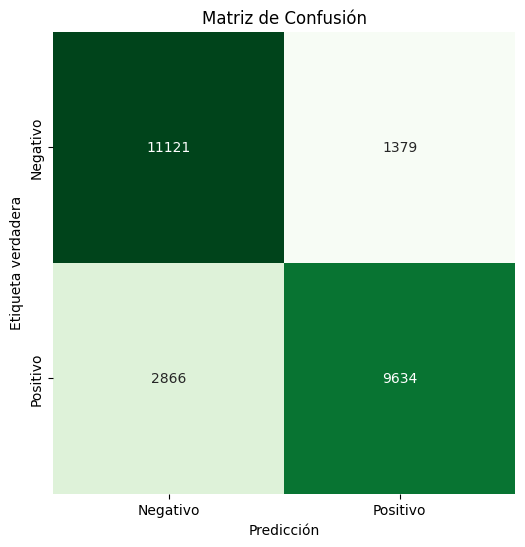

In [10]:
# Matriz de confusión
cm = confusion_matrix(test_labels, y_pred_test_tfidf)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, square=True,
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [12]:
# Reporte de clasficación
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_test = nb_model_tfidf.predict(X_test_tfidf)
classification_rep = classification_report(test_labels, y_pred_test)
print("Reporte de Clasificación:")
print(classification_rep)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     12500
           1       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



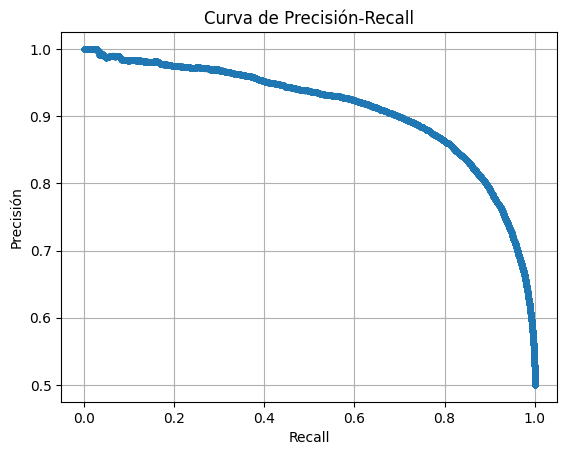

In [14]:
# Obtener las probabilidades de las predicciones para el conjunto de prueba
probs_test = nb_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Calcular la precisión y recall para diferentes umbrales
precision, recall, _ = precision_recall_curve(test_labels, probs_test)

# Graficar la curva de precisión y recall
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.grid(True)
plt.show()

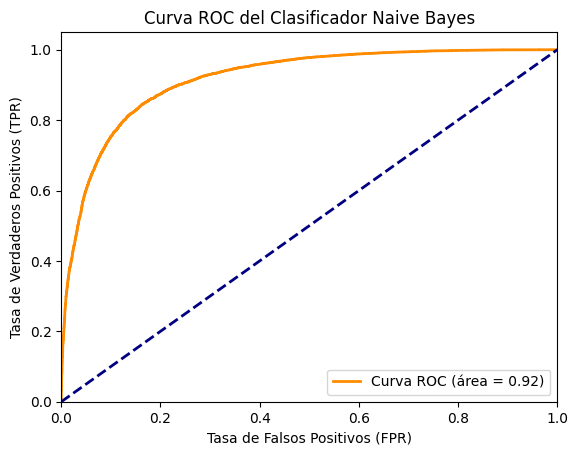

In [15]:
# Obtener las probabilidades de las predicciones positivas
y_prob_test = nb_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(test_labels, y_prob_test)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC del Clasificador Naive Bayes')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Obtener un comentario aleatorio, su etiqueta ("Esta reseña es positiva", "Esta reseña es negativa") y el nombre del archivo
def get_random_comment_and_label_test(directory, labels):
    sentiment = random.choice(['pos', 'neg'])
    sentiment_dir = os.path.join(directory, sentiment)
    file = random.choice(os.listdir(sentiment_dir))
    file_path = os.path.join(sentiment_dir, file)

    with open(file_path, 'r') as f:
        comment = f.read()

    label = "Esta reseña es positiva" if sentiment == 'pos' else "Esta reseña es negativa"
    return comment, label, file

# Ruta donde se descomprimirán los archivos
extracted_path = '/content/dataset'

# Traducir un texto al español
def translate_to_spanish(text):
    translator = Translator()
    translated_text = translator.translate(text, src='en', dest='es').text
    return translated_text

# Leemos las reseñas y etiquetas
def read_reviews_and_labels(directory):
    pass

# Obtenemos un comentario aleatorio del conjunto de prueba y su etiqueta
random_comment_test, random_label_test, random_file_test = get_random_comment_and_label_test(os.path.join(extracted_path, 'aclImdb/test'), test_labels)

# Preprocesamos el comentario de la misma manera que se preprocesaron las reseñas de entrenamiento
preprocessed_random_comment_test = preprocess_text(random_comment_test)

# Traducimos el comentario al español
translator = Translator()
translated_comment_test = translator.translate(preprocessed_random_comment_test, src='en', dest='es').text

# Transformamos el comentario en un vector TF-IDF utilizando el mismo vectorizador utilizado en el entrenamiento
random_comment_vector_test = tfidf_vectorizer.transform([preprocessed_random_comment_test])

# Hacemos la predicción utilizando el modelo Naive Bayes entrenado
predicted_sentiment_test = nb_model_tfidf.predict(random_comment_vector_test)

# El resultado de la predicción será un valor 0 o 1, donde 0 representa una reseña negativa y 1 representa una reseña positiva
if predicted_sentiment_test[0] == 0:
    predicted_label_test = "Esta reseña es negativa"
else:
    predicted_label_test = "Esta reseña es positiva"

# Mostrar el comentario original, su traducción al español, el nombre del archivo del comentario y el resto de la información
print("Comentario original del conjunto de prueba: ", random_comment_test)
print("Traducción al español del comentario elegido: ", translated_comment_test)
print("Nombre del archivo del comentario: ", random_file_test)
print("Etiqueta original del conjunto de prueba: ", random_label_test)
print("Predicción del modelo para el conjunto de prueba: ", predicted_label_test)

Comentario original del conjunto de prueba:  Simon West's remake of the 1979 horror classic is a pathetic attempt to bring old school thrills to a contemporary audience. Starring talented teen Camilla Belle, When a Stanger Calls fails to even elicit a shocked, or even surprised face. Poor attempts at scaring the audience range from blurred coats that look like people to building the tense music up for a cat running out of the shadows. The plot follows Jill Johnson (Belle), a teenage girl that has to pay off a bill to her father via babysitting. She is invited to work for the night at a house by the river, and thinks it a perfectly easy way to make cash. But little does she know, a stranger lurks in the house, and constantly harasses Johnson via the phone. A pathetic excuse for a film.
Traducción al español del comentario elegido:  La nueva versión de Simon West del Horror Classic de 1979 es un intento patético de llevar las emociones de la vieja escuela a una audiencia contemporánea.Pr